In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pybullet as p
import pybullet_data
import time

# --- PandaSim Class Definition ---
class PandaSim:
    def __init__(self, gui=True):
        self.gui = gui
        if gui:
            # Check if connected, if not connect
            if p.getConnectionInfo()['isConnected'] == 0:
                
                p.connect(p.GUI)
                p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)
                p.resetDebugVisualizerCamera(
                    cameraDistance=1.14,      # Zoom level (smaller = closer)
                    cameraYaw=30,            # Left/Right angle (degrees)
                    cameraPitch=-30,         # Up/Down angle (degrees, negative looks down)
                    cameraTargetPosition=[0.55, -0.15, 0.] # Focus point [x, y, z]
                )
        else:
             if p.getConnectionInfo()['isConnected'] == 0:
                p.connect(p.DIRECT)
        
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)
        # Load plane and robot
        if p.getNumBodies() == 0: # Avoid reloading if already loaded
            p.loadURDF("plane.urdf")
            self.robot_id = p.loadURDF("franka_panda/panda.urdf", useFixedBase=True)
        else:
            self.robot_id = 1 # Assuming index 1 if re-running

        self.arm_dof = 7
        self.ee_link_idx = 11
        self.last_ee_pos = None
        self.trace_enabled = True
        
        # Ready pose
        self.ready_pose = [0, -0.78, 0, -2.35, 0, 1.57, 0.78]
        self.reset_robot(self.ready_pose)

    def reset_robot(self, q):
        for i in range(self.arm_dof):
            p.resetJointState(self.robot_id, i, q[i])
            
    def get_joint_states(self):
        states = p.getJointStates(self.robot_id, range(self.arm_dof))
        q = np.array([s[0] for s in states])
        return q

    def get_ee_pose(self):
        state = p.getLinkState(self.robot_id, self.ee_link_idx)
        return np.array(state[0]), np.array(state[1])

    def get_jacobian(self, q):
        # Pad q with zeros for fingers to match PyBullet 9-DOF expectation
        full_q = list(q) + [0.0] * (9 - len(q))
        full_zeros = [0.0] * 9
        J_lin, J_ang = p.calculateJacobian(self.robot_id, self.ee_link_idx, [0,0,0], full_q, full_zeros, full_zeros)
        return np.array(J_lin)[:, :7], np.array(J_ang)[:, :7]
    
    def step(self):
        # Trace visualization
        current_ee_pos, _ = self.get_ee_pose()
        if self.trace_enabled and self.last_ee_pos is not None:
            p.addUserDebugLine(self.last_ee_pos, current_ee_pos, [0, 0, 1], 2.5, 0)
        self.last_ee_pos = current_ee_pos
        p.stepSimulation()
        if self.gui: time.sleep(1./240.)

    def clear_trace(self):
        p.removeAllUserDebugItems()
        self.last_ee_pos = None

# Initialize Global Simulator Instance
sim = PandaSim(gui=True)
print("Simulator Initialized.")

Simulator Initialized.


--- Exercise 1.1: Closed Form Trajectory ---


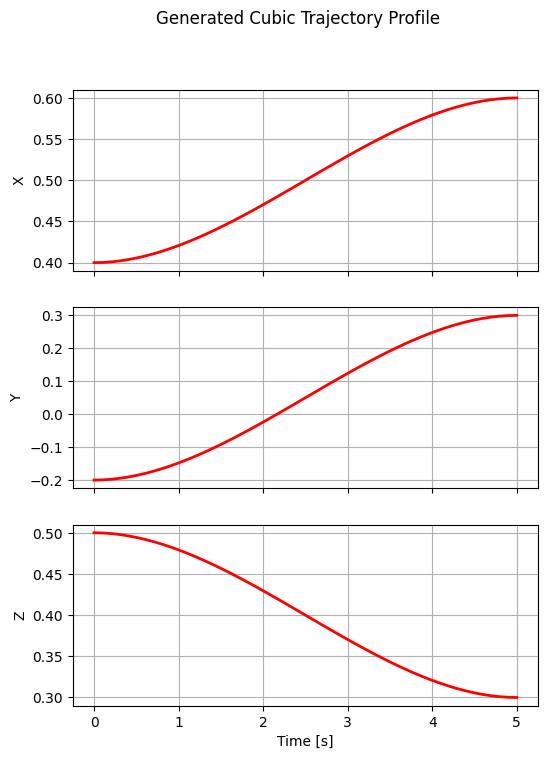

Executing on robot...
Done.



In [12]:
def exercise_1_1():
    print("--- Exercise 1.1: Closed Form Trajectory ---")
    sim.reset_robot(sim.ready_pose)
    sim.clear_trace()
    time.sleep(1)
    
    T = 5.0
    steps = 50
    time_vec = np.linspace(0, T, steps)
    
    # Define Start and Target
    p0 = np.array([0.4, -0.2, 0.5])
    pT = np.array([0.6, 0.3, 0.3])
    
    # Visual Markers
    start_visual = p.createMultiBody(baseVisualShapeIndex=p.createVisualShape(p.GEOM_SPHERE, radius=0.01, rgbaColor=[0,1,0,1]), basePosition=p0)
    target_visual = p.createMultiBody(baseVisualShapeIndex=p.createVisualShape(p.GEOM_SPHERE, radius=0.01, rgbaColor=[1,0,0,1]), basePosition=pT)

    cartesian_trajectory = np.zeros((3, steps))
    # Define the Matrix A for the cubic polynomial constraints [x(0), v(0), x(T), v(T)]
    # For x(t) = a0 + a1*t + a2*t^2 + a3*t^3
    # Boundary conditions: x(0)=p0, v(0)=0, x(T)=pT, v(T)=0
    # x(0) = a0 -> [1, 0, 0, 0]
    # v(0) = a1 -> [0, 1, 0, 0]
    # x(T) = a0 + a1*T + a2*T^2 + a3*T^3 -> [1, T, T^2, T^3]
    # v(T) = a1 + 2*a2*T + 3*a3*T^2 -> [0, 1, 2*T, 3*T^2]
    A = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [1, T, T**2, T**3],
            [0, 1, 2*T, 3*T**2]
        ])
    
    for dim in range(3):
        b = np.array([p0[dim], 0, pT[dim], 0])
        
        # Solve the linear system to find coefficients
        coeffs = np.linalg.solve(A, b)
        
        # Evaluate polynomial at all time steps
        cartesian_trajectory[dim, :] = (coeffs[0] + 
                                        coeffs[1] * time_vec + 
                                        coeffs[2] * time_vec**2 + 
                                        coeffs[3] * time_vec**3)


    # Plotting
    try:
        fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
        labels = ["X", "Y", "Z"]
        for i in range(3):
            axs[i].plot(time_vec, cartesian_trajectory[i, :], 'r-', lw=2)
            axs[i].set_ylabel(labels[i])
            axs[i].grid(True)
        plt.xlabel("Time [s]")
        plt.suptitle("Generated Cubic Trajectory Profile")
        plt.show()

        # Execute on Robot
        print("Executing on robot...")
        for i in range(steps):
            target_pos = cartesian_trajectory[:, i]
            q_sol = p.calculateInverseKinematics(sim.robot_id, sim.ee_link_idx, target_pos)
            sim.reset_robot(q_sol)
            sim.step()
            time.sleep(0.05)
    except Exception as e:
        print(f"Error executing trajectory: {e}")
    finally:
        p.removeBody(target_visual)
        p.removeBody(start_visual)
        print("Done.\n")

exercise_1_1()

In [26]:
def exercise_1_2():
    print("--- Exercise 1.2: Optimal Control ---")
    sim.reset_robot(sim.ready_pose)
    sim.clear_trace()
    time.sleep(1)
    
    dof = 7
    num_steps = 10
    start_q = np.array(sim.ready_pose)
    target_pos = np.array([0.6, 0.3, 0.2])
    
    # Visual Marker
    target_visual = p.createMultiBody(baseVisualShapeIndex=p.createVisualShape(p.GEOM_SPHERE, radius=0.03, rgbaColor=[1,0,0,1]), basePosition=target_pos)

    # Helper functions
    def unpack(x): 
        # x is [q1_0, q2_0, ..., q7_0, q1_1, ..., q7_N, Tf]
        # Returns: (N+1 x 7) array of joint configs, and Tf
        return x[:-1].reshape((num_steps, dof)), x[-1]
    
    def get_ee_pos_wrapper(q):
        sim.reset_robot(q) 
        pos, _ = sim.get_ee_pose()
        return pos

    # --- Implement Cost Functions ---
    def cost_min_time(x):
        # minimize final time
        q, Tf = unpack(x)
        return Tf

    def cost_min_task_dist(x):
        q_steps, Tf = unpack(x)
        # minimize cartesian path lengths
        total_dist = 0.0
        for i in range(1, num_steps):
            pos_prev = get_ee_pos_wrapper(q_steps[i-1])
            pos_curr = get_ee_pos_wrapper(q_steps[i])
            total_dist += np.linalg.norm(pos_curr - pos_prev)
        return total_dist

    def cost_min_joint_dist(x):
        q_steps, Tf = unpack(x)
        # Minimize Joint path length (sum of joint angle differences)
        total_dist = 0.0
        for i in range(1, num_steps):
            diff = q_steps[i] - q_steps[i-1]
            total_dist += np.sum(diff**2)  # Squared L2 norm (smoother gradient)
        return total_dist

    # --- Implement Velocity Constraints ---
    URDF_VELOCITY_LIMIT = 2.175
    def constraint_velocity(x):
        q_steps, Tf = unpack(x)
        dt = Tf / (num_steps - 1)
        
        # Calculate velocities for each transition
        constraints = []
        for i in range(num_steps - 1):
            dq = q_steps[i+1] - q_steps[i]
            # For each joint, check if velocity magnitude is within limits
            for j in range(dof):
                # Constraint: δqmax * dt - |dq[j]| >= 0
                # This ensures |dq[j]| / dt <= δqmax
                constraints.append(URDF_VELOCITY_LIMIT * dt - np.abs(dq[j]))
        
        return np.array(constraints)

    # Optimization Setup
    x0 = np.concatenate([np.tile(start_q, num_steps), [3.0]]) 
    
    cons = [
        {'type': 'eq', 'fun': lambda x: unpack(x)[0][0] - start_q},
        {'type': 'eq', 'fun': lambda x: get_ee_pos_wrapper(unpack(x)[0][-1]) - target_pos},
        {'type': 'ineq', 'fun': constraint_velocity}
    ]
    bounds = [(None, None)] * (num_steps*dof) + [(0.5, 10.0)]
    
    print("Optimizing... (Please wait)")
    
    # Switch between different cost functions to test
    res = minimize(cost_min_joint_dist, x0, constraints=cons, bounds=bounds, method='SLSQP')

    if res.success:
        final_time = res.x[-1]
        print(f"Optimization Successful! Cost: {res.fun:.4f}")
        print(f"Time: {final_time:.2f}s")
        
        q_traj, _ = unpack(res.x)
        for q in q_traj:
            sim.reset_robot(q)
            sim.step()
            time.sleep(0.2)
    else:
        print("Optimization Failed:", res.message)
    
    p.removeBody(target_visual)

exercise_1_2()

--- Exercise 1.2: Optimal Control ---
Optimizing... (Please wait)
Optimization Successful! Cost: 0.2847
Time: 3.05s


In [40]:
def exercise_1_3():
    print("--- Exercise 1.3: Replanning Under Disturbance ---")
    sim.reset_robot(sim.ready_pose)
    sim.clear_trace()
    p.removeAllUserDebugItems()
    time.sleep(1)
    
    dof = 7
    target_pos = np.array([0.6, 0.3, 0.2])
    start_q = np.array(sim.ready_pose)
    
    target_visual = p.createMultiBody(baseVisualShapeIndex=p.createVisualShape(p.GEOM_SPHERE, radius=0.03, rgbaColor=[1,0,0,1]), basePosition=target_pos)
    
    # Helper Optimizer for a segment - following optimization (c): minimize joint distance
    def optimize_segment(start_conf, target, steps):
        x0 = np.tile(start_conf, steps).flatten()
        
        # Cost function: minimize joint distance (Problem 1c)
        def cost(x): 
            q = x.reshape((steps, dof))
            total_dist = 0.0
            for i in range(1, steps):
                diff = q[i] - q[i-1]
                total_dist += np.sum(diff**2)
            return total_dist
        
        def get_fk(q_flat):
            sim.reset_robot(q_flat)
            return sim.get_ee_pose()[0]

        cons = [
            {'type':'eq', 'fun': lambda x: x[:dof] - start_conf},
            {'type':'eq', 'fun': lambda x: get_fk(x[-dof:]) - target}
        ]
        res = minimize(cost, x0, constraints=cons, method='SLSQP')
        return res.x.reshape((steps, dof)) if res.success else None

    # 1. Initial Plan
    print("1. Planning Initial Path (using optimization c: min joint distance)...")
    traj_initial = optimize_segment(start_q, target_pos, 20)
    
    if traj_initial is None:
        print("Initial plan failed.")
        return

    # Visualize Plan (Green)
    path_points = []
    for q in traj_initial:
        sim.reset_robot(q)
        pos, _ = sim.get_ee_pose()
        path_points.append(pos)
    for i in range(len(path_points) - 1):
        p.addUserDebugLine(path_points[i], path_points[i+1], lineColorRGB=[0, 1, 0], lineWidth=4, lifeTime=0)
    
    # Reset for Execution
    sim.reset_robot(start_q)

    # 2. Apply Disturbance midpath
    mid_idx = 10
    q_mid = traj_initial[mid_idx].copy()
    
    print("2. Applying disturbance to elbow joint midpath...")
    q_disturbed = q_mid.copy()
    q_disturbed[3] += 0.8  # Significant push to elbow joint
    
    # 3. Replan from Disturbed State using residual time
    print("3. Replanning from disturbed configuration...")
    remaining_steps = len(traj_initial) - mid_idx
    traj_replan = optimize_segment(q_disturbed, target_pos, remaining_steps)
    
    if traj_replan is None:
        print("Replanning failed!")
        traj_replan = np.array([q_disturbed])
    
    # 4. Stitch trajectories
    # Combine: initial trajectory (0 to mid_idx-1) + replanned trajectory (from disturbed state)
    full_traj = np.vstack([traj_initial[:mid_idx], traj_replan])
    
    print(f"Stitched trajectory: {len(traj_initial[:mid_idx])} initial steps + {len(traj_replan)} replanned steps")
    
    # Execute sequence
    print("Executing sequence...")
    
    # Execute initial part up to disturbance
    for i in range(mid_idx):
        sim.reset_robot(full_traj[i])
        sim.step()
        time.sleep(0.1)
    
    # Show disturbance
    print("  -> Disturbance applied!")
    sim.reset_robot(q_disturbed)
    sim.step()
    time.sleep(0.5) 
    
    # Execute replanned trajectory
    for i in range(mid_idx, len(full_traj)):
        sim.reset_robot(full_traj[i])
        sim.step()
        time.sleep(0.1)
    
    print("Execution complete.")
    p.removeBody(target_visual)

exercise_1_3()

--- Exercise 1.3: Replanning Under Disturbance ---
1. Planning Initial Path (using optimization c: min joint distance)...
2. Applying disturbance to elbow joint midpath...
3. Replanning from disturbed configuration...
Stitched trajectory: 10 initial steps + 10 replanned steps
Executing sequence...
  -> Disturbance applied!
Execution complete.


In [41]:
def exercise_1_4():
    print("--- Exercise 1.4: Jacobian Inverse Kinematics ---")
    print("Following Algorithm 1: Generate Kinematically Feasible Trajectories")
    print("""
    Algorithm:
    - Compute error: e = x* - F(q)
    - Compute desired Cartesian velocity: ė = gain * e (proportional control)
    - Compute joint velocity: q̇ = J† · ė
    - Update joints: q(t+dt) = q(t) + q̇ · dt
    """)
    sim.reset_robot(sim.ready_pose)
    sim.clear_trace()
    time.sleep(1)
    
    # a) Initialization
    start_pos, _ = sim.get_ee_pose()
    target_pos = start_pos + np.array([0.2, 0.2, -0.2])  # x* (target)
    
    target_visual = p.createMultiBody(baseVisualShapeIndex=p.createVisualShape(p.GEOM_SPHERE, radius=0.02, rgbaColor=[1,0,0,1]), basePosition=target_pos)
    
    dt = 0.05  # Time step
    lambda_val = 0.05  # Damping factor for robustness near singularities
    epsilon = 0.01  # Tolerance for convergence
    gain = 1.0  # Proportional gain for velocity control
    
    q = np.array(sim.ready_pose)  # q(0) - known start configuration
    t = 0  # Initialize time
    
    print(f"Target position: {target_pos}")
    print(f"Using Damped Pseudo-Inverse with λ={lambda_val}")
    
    # b) Main Loop - Algorithm 1
    max_iterations = 300
    iteration = 0
    
    while iteration < max_iterations:
        sim.reset_robot(q)
        
        # Get current end-effector position (F(q(t)))
        curr_pos, _ = sim.get_ee_pose()
        
        # Compute error e = x* - F(q(t))
        error = target_pos - curr_pos
        error_norm = np.linalg.norm(error)
        if error_norm < epsilon:
            print(f"Target Reached! Final error: {error_norm:.6f}m after {iteration} iterations ({t:.2f}s)")
            break
        
        # Compute Jacobian J(q)
        J_lin, _ = sim.get_jacobian(q)
        
        # Compute Damped Pseudo-Inverse J† = J^T(JJ^T + λ²I)^(-1)
        I = np.eye(3)
        J_pinv = J_lin.T @ np.linalg.inv(J_lin @ J_lin.T + lambda_val**2 * I)
        
        # Compute desired Cartesian velocity (ė_desired)
        # Using proportional control: velocity is proportional to error
        e_dot = gain * error
        
        # Compute joint velocity: q̇ = J† · ė
        q_dot = J_pinv @ e_dot
        
        # Update q(t + dt) = q(t) + q̇ * dt
        q = q + q_dot * dt
        
        # Update time
        t = t + dt
        iteration += 1
        
        sim.step()
        time.sleep(0.02)
    
    if iteration >= max_iterations:
        print(f"Maximum iterations reached. Final error: {np.linalg.norm(error):.6f}m")
    
    p.removeBody(target_visual)
    print("\nExercise 1.4 complete.")

exercise_1_4()

--- Exercise 1.4: Jacobian Inverse Kinematics ---
Following Algorithm 1: Generate Kinematically Feasible Trajectories

    Algorithm:
    - Compute error: e = x* - F(q)
    - Compute desired Cartesian velocity: ė = gain * e (proportional control)
    - Compute joint velocity: q̇ = J† · ė
    - Update joints: q(t+dt) = q(t) + q̇ · dt
    
Target position: [0.50834825 0.2        0.28647499]
Using Damped Pseudo-Inverse with λ=0.05
Target Reached! Final error: 0.009999m after 71 iterations (3.55s)

Exercise 1.4 complete.


### **End of Demo**
Run the cell below to disconnect the simulator properly.

In [15]:
p.disconnect()
print("Simulator disconnected.")

Simulator disconnected.numActiveThreads = 0
stopping threads
destroy semaphore
semaphore destroyed
Thread with taskId 0 exiting
Thread TERMINATED
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed

